In [10]:
# If using JAX in TPU VM, do this first to stop the notebook locking up all the processes

import os

# 2x 2 chips (4 cores) per process:
os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,2,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "0,1"  # Change to "2,3" for the second machine
# Pick a unique port per process
os.environ["TPU_MESH_CONTROLLER_ADDRESS"] = "localhost:8476"
os.environ["TPU_MESH_CONTROLLER_PORT"] = "8476"

print("done")

done


In [1]:
import jax

print(jax.devices())

[CpuDevice(id=0)]


In [2]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

from jax import random

key = random.PRNGKey(42)

In [5]:
ndomains = 10
nclasses = 2
nfactors = 2
nlabels = nclasses * nfactors

[[-2.         -0.66666667]
 [ 0.66666667  2.        ]]


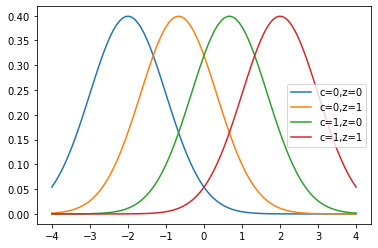

In [6]:
# Generative model: p(x|m) = N(x | mu_m, sigma^2) where m=(c,z)
sigma = 1
mus = np.linspace(-2, 2, num=nlabels)
mus = np.reshape(mus, [nclasses, nfactors])  # mus[c, z]
print(mus)


def class_cond_density(c, z):  # p(x|c,z)
    dist = scipy.stats.norm(loc=mus[c, z], scale=sigma)
    return dist


xs = np.linspace(-4, 4, 100)
plt.figure()
for c in range(nclasses):
    for z in range(nfactors):
        dist = class_cond_density(c, z)
        probs = dist.pdf(xs)
        lab = "c={:d},z={:d}".format(c, z)
        plt.plot(xs, probs, label=lab)
plt.legend()

In [7]:
def make_label_prior(domain):
    p_class = (1 / nclasses) * jnp.ones(nclasses)
    rho = domain / ndomains  # rho = prob that class label is different from latent factor
    p_factor_given_class = np.zeros((2, 2))  # (c,z) so each row sums to 1
    p_factor_given_class[0, :] = [1 - rho, rho]
    p_factor_given_class[1, :] = [rho, 1 - rho]
    p_label = np.zeros((nclasses, nfactors))  # (c,z)
    for c in range(nclasses):
        for z in range(nfactors):
            p_label[c, z] = p_class[c] * p_factor_given_class[c, z]
    return p_label


label_prior = make_label_prior(1)
print(label_prior)

[[0.44999999 0.05      ]
 [0.05       0.44999999]]


In [9]:
def make_post_class0(xs, label_prior):  # Bayes rule using true generative model
    ndata = len(xs)
    label_post = np.zeros((nclasses, nfactors, ndata))
    for c in range(nclasses):
        for z in range(nfactors):
            dist = class_cond_density(c, z)
            label_post[c, z, :] = label_prior[c, z] * dist.pdf(xs)
    px = np.sum(label_post, axis=[0, 1])  # normalizer
    label_post = label_post / np.reshape(px, ((1, 1, ndata)))
    class_post = np.sum(label_post, axis=1)  # sum over z
    return class_post


ndata = len(xs)
label_post = np.zeros((nclasses, nfactors, ndata))
for c in range(nclasses):
    for z in range(nfactors):
        dist = class_cond_density(c, z)
        label_post[c, z, :] = label_prior[c, z] * np.array(dist.pdf(xs))

print(label_post.shape)
px = np.sum(label_post, axis=(0, 1))  # normalizer
print(px.shape)
label_post = label_post / np.reshape(px, ((1, 1, ndata)))
print(label_post.shape)
class_post = np.sum(label_post, axis=1)  # sum over z
print(class_post.shape)
label_prior = make_label_prior(1)
x = 0.5
label_post = make_post_class0(x, label_prior)
print(label_post)

(2, 2, 100)
(100,)
(2, 2, 100)
(2, 100)


TypeError: object of type 'float' has no len()